### Working with Avro files

Here are some examples of working with ZTF alerts stored as avro files.

In [46]:
import os
import io
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter
import fastavro

from astropy.time import Time
from astropy.io import fits
import aplpy
%matplotlib inline

A handful of sample alerts are available in the [ztf-avro-alert](https://github.com/ZwickyTransientFacility/ztf-avro-alert) repository, which also [documents](https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html) the packet contents.

In [47]:
DATA_DIR = '~/Downloads/ztf_public_20201106/'

Let's count packets. Let's use a generator--we could eventually have millions of these alerts to look at!

In [48]:
def find_files(root_dir):
    for dir_name, subdir_list, file_list in os.walk(os.path.expanduser(root_dir), followlinks=True):
        for fname in file_list:
            if fname.endswith('.avro'):
                yield dir_name+'/'+fname

In [49]:
print('{} has {} avro files'.format(DATA_DIR, len(list(find_files(DATA_DIR)))))

~/Downloads/ztf_public_20201106/ has 41374 avro files


Let's grab the first file and look at it

In [50]:
files_gen = find_files(DATA_DIR)
fname = next(files_gen)

In [51]:
fname

'/home/rostskadat/Downloads/ztf_public_20201106//1405470501015015011.avro'

Let's use the python `avro` library to see what's in the file.

In [52]:
%%time
with open(fname,'rb') as f:
    freader = DataFileReader(f,DatumReader())
    for packet in freader:
        print(packet.keys())

dict_keys(['schemavsn', 'publisher', 'objectId', 'candid', 'candidate', 'prv_candidates', 'cutoutScience', 'cutoutTemplate', 'cutoutDifference'])
CPU times: user 98.2 ms, sys: 564 µs, total: 98.8 ms
Wall time: 98.4 ms


Now let's compare the call syntax of the faster `fastavro` package:

In [53]:
%%time 
with open(fname,'rb') as f:
    freader = fastavro.reader(f)
    schema = freader.schema

    for packet in freader:
        print(packet.keys())

dict_keys(['schemavsn', 'publisher', 'objectId', 'candid', 'candidate', 'prv_candidates', 'cutoutScience', 'cutoutTemplate', 'cutoutDifference'])
CPU times: user 5.69 ms, sys: 78 µs, total: 5.77 ms
Wall time: 5.15 ms


<timed exec>:3: DeprecationWarning: The 'schema' attribute is deprecated. Please use 'writer_schema'


Basically the same, and the latter is faster.  Here's the schema that was stored in the packet:

In [54]:
schema

{'doc': 'avro alert schema for ZTF (www.ztf.caltech.edu)',
 'fields': [{'doc': 'schema version used',
   'name': 'schemavsn',
   'type': 'string'},
  {'doc': 'origin of alert packet', 'name': 'publisher', 'type': 'string'},
  {'doc': 'object identifier or name', 'name': 'objectId', 'type': 'string'},
  {'name': 'candid', 'type': 'long'},
  {'name': 'candidate',
   'type': {'doc': 'avro alert schema',
    'fields': [{'doc': 'Observation Julian date at start of exposure [days]',
      'name': 'jd',
      'type': 'double'},
     {'doc': 'Filter ID (1=g; 2=R; 3=i)', 'name': 'fid', 'type': 'int'},
     {'doc': 'Processing ID for science image to facilitate archive retrieval',
      'name': 'pid',
      'type': 'long'},
     {'default': None,
      'doc': 'Expected 5-sigma mag limit in difference image based on global noise estimate [mag]',
      'name': 'diffmaglim',
      'type': ['null', 'float']},
     {'default': None,
      'doc': 'filename of positive (sci minus ref) difference image'

Once we have the packet in python data structures our downstream processing should be independent of how we got the packet (from files or from a Kafka stream).

### Playing with packet contents

Once these are in memory they are just a python dictionary, so the top-level attributes are easy to access.

In [55]:
type(packet)

dict

In [56]:
packet

{'schemavsn': '3.3',
 'publisher': 'ZTF (www.ztf.caltech.edu)',
 'objectId': 'ZTF20acpgdsq',
 'candid': 1405470501015015011,
 'candidate': {'jd': 2459159.9705093,
  'fid': 2,
  'pid': 1405470501015,
  'diffmaglim': 20.106834411621094,
  'pdiffimfilename': 'ztf_20201106470509_000813_zr_c03_o_q3_scimrefdiffimg.fits',
  'programpi': 'Kulkarni',
  'programid': 1,
  'candid': 1405470501015015011,
  'isdiffpos': 't',
  'tblid': 11,
  'nid': 1405,
  'rcid': 10,
  'field': 813,
  'xpos': 1004.60791015625,
  'ypos': 2427.73046875,
  'ra': 97.7778457,
  'dec': 58.5764091,
  'magpsf': 19.959449768066406,
  'sigmapsf': 0.2149713784456253,
  'chipsf': 1.822272539138794,
  'magap': 19.767200469970703,
  'sigmagap': 0.29660001397132874,
  'distnr': 11.045767784118652,
  'magnr': 22.618000030517578,
  'sigmagnr': 0.32499998807907104,
  'chinr': 0.8140000104904175,
  'sharpnr': -0.31200000643730164,
  'sky': 0.6024903059005737,
  'magdiff': -0.19224999845027924,
  'fwhm': 2.869999885559082,
  'classtar

In [57]:
print('JD: {} Filter: {} Mag: {:.2f}+/-{:.2f}'.format(
    packet['candidate']['jd'],packet['candidate']['fid'],
    packet['candidate']['magpsf'],packet['candidate']['sigmapsf']))

JD: 2459159.9705093 Filter: 2 Mag: 19.96+/-0.21


**NOTE ESPECIALLY**: the magnitudes here do not include the magnitude of the underlying reference source (if present), so if this is a variable star further adjustment is needed.  Example to come...

Record access like this is a little verbose; let's wrap things up in a dataframe for ease of access (and faster loading).

Now let's extract the lightcurves.  The alert packet formats are nested, so the historical detections (if present) have the same structure as the candidate triggering the alert (minus a couple fields).

In [58]:
def make_dataframe(packet):
    df = pd.DataFrame(packet['candidate'], index=[0])
    df_prv = pd.DataFrame(packet['prv_candidates'])
    return pd.concat([df,df_prv], ignore_index=True)

In [59]:
dflc = make_dataframe(packet)
dflc

,jd,fid,pid,diffmaglim,pdiffimfilename,programpi,programid,candid,isdiffpos,tblid,...,zpmed,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime,drb,drbversion
0,2.459160e+06,2,1405470501015,20.106834,ztf_20201106470509_000813_zr_c03_o_q3_scimrefd...,Kulkarni,1,1405470501015015011,t,11,...,26.308001,0.572,0.273374,20.051233,-999.0,17.082209,-999.0,30.0,0.151717,d6_m7
1,2.459130e+06,2,1375487741015,20.088301,/ztf/archive/sci/2020/1007/487732/ztf_20201007...,Kulkarni,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.459130e+06,2,1375491074915,20.135201,/ztf/archive/sci/2020/1007/491076/ztf_20201007...,Kulkarni,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.459132e+06,1,1377355751015,19.235201,/ztf/archive/sci/2020/1009/355741/ztf_20201009...,Kulkarni,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.459132e+06,1,1377380874915,18.863100,/ztf/archive/sci/2020/1009/380868/ztf_20201009...,Kulkarni,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2.459136e+06,2,1381408194915,20.509001,/ztf/archive/sci/2020/1013/408194/ztf_20201013...,Kulkarni,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2.459136e+06,2,1381409591015,20.441099,/ztf/archive/sci/2020/1013/409595/ztf_20201013...,Kulkarni,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2.459136e+06,1,1381430551015,20.633900,/ztf/archive/sci/2020/1013/430556/ztf_20201013...,Kulkarni,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2.459136e+06,1,1381431034915,20.720301,/ztf/archive/sci/2020/1013/431018/ztf_20201013...,Kulkarni,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.459138e+06,2,1383391881015,20.349501,/ztf/archive/sci/2020/1015/391863/ztf_20201015...,Kulkarni,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
dflc.columns

Index(['jd', 'fid', 'pid', 'diffmaglim', 'pdiffimfilename', 'programpi',
       'programid', 'candid', 'isdiffpos', 'tblid',
       ...
       'zpmed', 'clrmed', 'clrrms', 'neargaia', 'neargaiabright', 'maggaia',
       'maggaiabright', 'exptime', 'drb', 'drbversion'],
      dtype='object', length=103)

We see that some of the historical detections are upper limits, signified by the NaNs.  Note that the most recent candidate has a few fields that are not present for the `prv_candidates`.

Let's plot it!

In [61]:
def plot_lightcurve(dflc, days_ago=True):
    
    filter_color = {1:'green', 2:'red', 3:'pink'}
    if days_ago:
        now = Time.now().jd
        t = dflc.jd - now
        xlabel = 'Days Ago'
    else:
        t = dflc.jd
        xlabel = 'Time (JD)'
    
    plt.figure()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
        if np.sum(w):
            plt.errorbar(t[w],dflc.loc[w,'magpsf'], dflc.loc[w,'sigmapsf'],fmt='.',color=color)
        wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
        if np.sum(wnodet):
            plt.scatter(t[wnodet],dflc.loc[wnodet,'diffmaglim'], marker='v',color=color,alpha=0.25)
    
    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Magnitude')
    

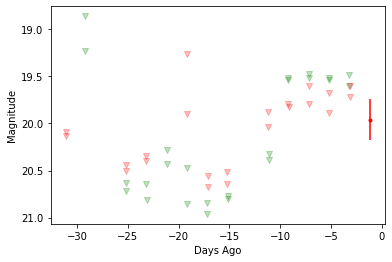

In [62]:
plot_lightcurve(dflc)

Now let's figure out how to display the cutout images.  These are gzip-compressed fits files stored as bytes:

In [63]:
packet['cutoutScience']

{'fileName': 'candid1405470501015015011_pid1405470501015_targ_sci.fits.gz',
 'stampData': b'\x1f\x8b\x08\x00E3\xa5_\x02\x03\xed\xbbi\xbcMu\xfc\xfe-\t!$I\x92$s\x08E\xa6N\xf2>\x84\x90\x10\x92L!I\x92\xcc\x84\x10\x92\x99\x84\x84s\xce\x9e\xd6\xbc\xd6\xde\xfbL\x08!$$!S\x12%!3I\x86\xffU\xffg\xf7\xeb\xff\xe4\xfe\xdf\xbf\xd7\xfd\xa8\xf5\x04\xc7\xdek\x7f\xd7g\xb8\xae\xf7u8\x1d[\xb5m\xdf\xa6y\xf9\xf2\xcf\x94/\xdf\xa9\xfc\xff\xc0\xd5\xacU\xa7\xf6\xad\xba\xfe{\xbf\xff\xe7U\xf3\xc9\xba\xff\xef\xef\xd7\xee\xb9\xae\xad:\x96\xff?\xde\xaf|\xf9\xff\xdb\xfb\xd5\xf9?\xdf\xaf\xfe\x93\xff\x97\xf7\xab\xfb?w\xbff/\xb7k\xd5\xe9\xdf\xe7\xad\x92\xda\xee\x7f\x7f\xa9\xca\xff\x97~4o\x97Z\xfe\xbf\xeb\xbf\xeb\xbf\xeb\xbf\xeb\xbf\xeb\xbf\xeb\xbf\xeb\xbf\xeb\xbf\xeb\x7f\xee"\xfe]S\xe2\xdd\xd7\x13=V\x0b\xf7{\x97\xc8\x0be\x887i\x843\xaa \xe6\xad\x18\xde\x8e\xe5\xb8\x87{`\x1d\x1cE\xec\xd3\xda\x04\x17j\xe35\xdd\x85\x93u\x8dX\xee>\xec\x1b\xdd0\xc7\x96\xc4\xae8\x94\xd0\x11\x1f\xe3\xa9\x16\x98\xad\xd7\xe0\x98\x95q_8\x8c9\xefi\

In [64]:
stamp = packet['cutoutScience']['stampData']

In [65]:
type(stamp)

bytes

In [66]:
def plot_cutout(stamp, fig=None, subplot=None, **kwargs):
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdul:
            if fig is None:
                fig = plt.figure(figsize=(4,4))
            if subplot is None:
                subplot = (1,1,1)
            ffig = aplpy.FITSFigure(hdul[0],figure=fig, subplot=subplot, **kwargs)
            ffig.show_grayscale(stretch='power')
    return ffig

INFO: Auto-setting vmin to  3.193e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.415e+02 [aplpy.core]


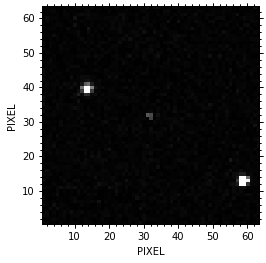

In [67]:
plot_cutout(stamp)

Now let's make a nice helper function:

In [68]:
def show_stamps(packet):
    #fig, axes = plt.subplots(1,3, figsize=(12,4))
    fig = plt.figure(figsize=(12,4))
    for i, cutout in enumerate(['Science','Template','Difference']):
        stamp = packet['cutout{}'.format(cutout)]['stampData']
        ffig = plot_cutout(stamp, fig=fig, subplot = (1,3,i+1))
        ffig.set_title(cutout)

INFO: Auto-setting vmin to  3.193e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.415e+02 [aplpy.core]


INFO: Auto-setting vmin to  3.409e+02 [aplpy.core]
INFO: Auto-setting vmax to  6.379e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.106e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.828e+01 [aplpy.core]


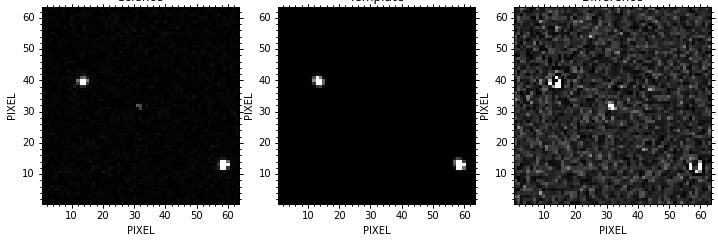

In [69]:
show_stamps(packet)